In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import time
import numpy as np
import geopandas as gpd
import xarray as xr
import os
from itertools import product
from scipy.stats import pearsonr
import numpy as np
import random

In [2]:
class WaterModel:
    def __init__(self, params, data):
        self.params = params
        self.data = data

    def calc_et_weight(self, temp, ndvi, w):
        """Calculate influence of LAI and temperature on ET.
            Input: temp: temperature data [K]
            lai: leaf area index data [m**2/m**2]
            w: weights for temperature and lai"""
        # Get coefficients for temperature and lai
        temp_w, lai_w = w
        ndvi = np.nan_to_num(ndvi, nan=0)
        temp_min = temp.min()
        temp_max = temp.max()
        lai_min = ndvi.min()
        lai_max = ndvi.max()

        # Perform normalization
        normalized_temp = (temp - temp_min) / (temp_max - temp_min)
        normalized_lai = (ndvi - lai_min) / (lai_max - lai_min)

        # Weight Temperature and LAI
        et_coef = temp_w * normalized_temp + lai_w * normalized_lai
        return et_coef

    def water_balance(self, w_t, prec_t, rad_t, snow_t, temp_t, cs, alpha, beta, gamma, c_m):
        """ Calculates the water balance for one time step as introduced in the lecture. Added features, such as snow"""
        snow_t, prec_t = self.snow_function(snow_t, prec_t, temp_t,
                                c_m)  # overwrites the precipitation (if snow melts or precipitation is accumulated as snow)
        runoff_t = self.runoff(w_t, prec_t, cs, alpha)
        evapo_t = self.evapotranspiration(w_t, rad_t, cs, beta, gamma)
        w_next = w_t + (prec_t - evapo_t - runoff_t)
        w_next = np.maximum(0, w_next)
        
        return runoff_t, evapo_t, w_next, snow_t

    def runoff(self, w_t, prec_t, cs, alpha):
        return w_t * (w_t / cs) ** alpha

    def evapotranspiration(self, w_t, rad_t, cs, beta, gamma):
        return beta * (w_t / cs) ** gamma * rad_t

    def snow_function(self, snow_t, prec_t, temp_t, c_m):
        # Determine if temperature is above freezing (melting condition)
        is_melting = temp_t > 273.15
        
        # Determine if there is already snow on the ground
        has_snow = snow_t >= 0.001

        if not is_melting:
            # Temperature is below or at freezing → precipitation adds to snow
            snow_out = snow_t + prec_t
            water_out = 0.0
        elif is_melting and has_snow:
            # Snow is present and temperature is above freezing → melt snow
            SnowMelt = c_m * (temp_t - 273.15)
            snow_out = snow_t - SnowMelt
            if snow_out < 0:
                SnowMelt = snow_t  # Can't melt more than exists
                snow_out = 0.0
            water_out = SnowMelt + prec_t
        else:
            # No snow, and temperature above freezing → all precip is rain
            snow_out = snow_t
            water_out = prec_t

        return snow_out, water_out

    def time_evolution(self, temp, rad, prec, ndvi, params):
        runoff_out = np.full_like(temp, np.nan)
        evapo_out = np.full_like(temp, np.nan)
        soil_mois_out = np.full_like(temp, np.nan)
        snow_out = np.full_like(temp, np.nan)
        
        if np.all(np.isnan(ndvi)):
            #edge case for no vegetation
            return runoff_out, evapo_out, soil_mois_out, snow_out
        cs, alpha, gamma, beta, c_m, et_weight = params
        #conversion factor

        conv = 1 / 2260000  # from J/day/m**2 to mm/day
        rad = rad * conv  # convert radiation to mm/day
        prec = prec * 10 **3 # from m/day to mm/day
        
        w_0 = 0.9 * cs
        snow_0 = 0
        
        beta_weighted = beta * self.calc_et_weight(temp, ndvi, et_weight)
        
        for t in range(1, len(temp)):
            prec_t = prec[t-1]
            temp_t = temp[t-1]
            rad_t = rad[t-1]
            beta_weighted_t = beta_weighted[t-1]
            runoff_out[t], evapo_out[t], soil_mois_out[t], snow_out[t] = self.water_balance(
                w_0, prec_t, rad_t, snow_0, temp_t, cs, alpha, beta_weighted_t, gamma, c_m)
            w_0 = soil_mois_out[t]
            snow_0 = snow_out[t]
        return runoff_out, evapo_out, soil_mois_out, snow_out
    
    def run_simulation(self):
        runoff, evapo, soil_mois, snow = xr.apply_ufunc(
            self.time_evolution,
            self.data['temperature'],
            self.data['radiation'],
            self.data['precipitation'],
            self.data['ndvi'],
            kwargs={'params': self.params},
            input_core_dims=[['time'], ['time'], ['time'], ['time']],
            output_core_dims=[['time'], ['time'], ['time'], ['time']],
            vectorize=True,
            dask='allowed',
            output_dtypes=[np.float64, np.float64, np.float64, np.float64])

        results = xr.Dataset({
                'runoff': runoff,
                'evapotranspiration': evapo,
                'soil_moisture': soil_mois,
                'snow': snow
            })
        return results
        
    def run_simulation_whole_catchment(self):
        runoff,_,_,_= self.time_evolution(temp = self.data['temperature'],
                                          rad = self.data['radiation'],
                                          prec = self.data['precipitation'],
                                          ndvi = self.data['ndvi'],
                                          params = self.params)
        return xr.Dataset({'runoff': runoff})
        
        

In [3]:
class WaterModel_New:
    def __init__(self, params, data):
        self.params = params
        self.data = data

    def calc_et_weight(self, temp, ndvi, w):
        """Calculate influence of LAI and temperature on ET.
            Input: temp: temperature data [K]
            lai: leaf area index data [m**2/m**2]
            w: weights for temperature and lai"""
        # Get coefficients for temperature and lai
        temp_w, lai_w = w
        ndvi = np.nan_to_num(ndvi, nan=0)
        temp_min = temp.min()
        temp_max = temp.max()
        lai_min = ndvi.min()
        lai_max = ndvi.max()

        # Perform normalization
        normalized_temp = (temp - temp_min) / (temp_max - temp_min)
        normalized_lai = (ndvi - lai_min) / (lai_max - lai_min)

        # Weight Temperature and LAI
        et_coef = temp_w * normalized_temp + lai_w * normalized_lai
        return et_coef

    def water_balance(self, w_t, prec_t, rad_t, snow_t, temp_t, cs, alpha, beta, gamma, c_m, iota):
        """ Calculates the water balance for one time step as introduced in the lecture. Added features, such as snow"""
        snow_t, prec_t = self.snow_function(snow_t, prec_t, temp_t,
                                c_m)  # overwrites the precipitation (if snow melts or precipitation is accumulated as snow)
        runoff_t = self.runoff(w_t, prec_t, cs, alpha, iota)
        evapo_t = self.evapotranspiration(w_t, rad_t, cs, beta, gamma)
        w_next = w_t + (prec_t - evapo_t - runoff_t)
        w_next = np.maximum(0, w_next)
        
        return runoff_t, evapo_t, w_next, snow_t

    def runoff(self, w_t, prec_t, cs, alpha, iota):
        return (prec_t + iota) * (w_t / cs) ** alpha

    def evapotranspiration(self, w_t, rad_t, cs, beta, gamma):
        return beta * (w_t / cs) ** gamma * rad_t

    def snow_function(self, snow_t, prec_t, temp_t, c_m):
        # Determine if temperature is above freezing (melting condition)
        is_melting = temp_t > 273.15
        
        # Determine if there is already snow on the ground
        has_snow = snow_t >= 0.001

        if not is_melting:
            # Temperature is below or at freezing → precipitation adds to snow
            snow_out = snow_t + prec_t
            water_out = 0.0
        elif is_melting and has_snow:
            # Snow is present and temperature is above freezing → melt snow
            SnowMelt = c_m * (temp_t - 273.15)
            snow_out = snow_t - SnowMelt
            if snow_out < 0:
                SnowMelt = snow_t  # Can't melt more than exists
                snow_out = 0.0
            water_out = SnowMelt + prec_t
        else:
            # No snow, and temperature above freezing → all precip is rain
            snow_out = snow_t
            water_out = prec_t

        return snow_out, water_out

    def time_evolution(self, temp, rad, prec, ndvi, params):
        runoff_out = np.full_like(temp, np.nan)
        evapo_out = np.full_like(temp, np.nan)
        soil_mois_out = np.full_like(temp, np.nan)
        snow_out = np.full_like(temp, np.nan)
        
        if np.all(np.isnan(ndvi)):
            #edge case for no vegetation
            return runoff_out, evapo_out, soil_mois_out, snow_out
        cs, alpha, gamma, beta, c_m, et_weight, iota = params
        #conversion factor

        conv = 1 / 2260000  # from J/day/m**2 to mm/day
        rad = rad * conv  # convert radiation to mm/day
        prec = prec * 10 **3 # from m/day to mm/day
        
        w_0 = 0.9 * cs
        snow_0 = 0
        
        beta_weighted = beta * self.calc_et_weight(temp, ndvi, et_weight)
        
        for t in range(1, len(temp)):
            prec_t = prec[t-1]
            temp_t = temp[t-1]
            rad_t = rad[t-1]
            beta_weighted_t = beta_weighted[t-1]
            runoff_out[t], evapo_out[t], soil_mois_out[t], snow_out[t] = self.water_balance(
                w_0, prec_t, rad_t, snow_0, temp_t, cs, alpha, beta_weighted_t, gamma, c_m, iota)
            w_0 = soil_mois_out[t]
            snow_0 = snow_out[t]
            
        return runoff_out, evapo_out, soil_mois_out, snow_out
    
    def run_simulation(self):
        runoff, evapo, soil_mois, snow = xr.apply_ufunc(
            self.time_evolution,
            self.data['temperature'],
            self.data['radiation'],
            self.data['precipitation'],
            self.data['ndvi'],
            kwargs={'params': self.params},
            input_core_dims=[['time'], ['time'], ['time'], ['time']],
            output_core_dims=[['time'], ['time'], ['time'], ['time']],
            vectorize=True,
            dask='allowed',
            output_dtypes=[np.float64, np.float64, np.float64, np.float64])

        results = xr.Dataset({
                'runoff': runoff,
                'evapotranspiration': evapo,
                'soil_moisture': soil_mois,
                'snow': snow
            })
        return results
        
    def run_simulation_whole_catchment(self):
        runoff,_,_,_= self.time_evolution(temp = self.data['temperature'],
                                          rad = self.data['radiation'],
                                          prec = self.data['precipitation'],
                                          ndvi = self.data['ndvi'],
                                          params = self.params)
        return xr.Dataset({'runoff': runoff})
        
        

In [4]:
class Calibrator:
    def __init__(self, paramsChoice, rasterData, amountCombinations = 3):
        "Rasterdata needs the layers Precipitation, Radiation, Temperature, NDVI and observedRunoff"
        self.paramsChoice = paramsChoice
        self.rasterData = rasterData
        self.amountCombinations = amountCombinations

    def calibration(self):
        amount_combinations = 3
        all_combinations = list(product(*self.paramsChoice.values()))
        random_combinations = random.sample(all_combinations, amount_combinations)
        
        best_r = -np.inf
        best_params = None
        
        for params in random_combinations:
            wm = WaterModel(params=params, data=self.rasterData)
            results = wm.run_simulation()
            runoff = results["runoff"].values.flatten()
            observed = self.rasterData.values.flatten()

            mask = ~np.isnan(runoff) & ~np.isnan(observed)
            if np.sum(mask) < 2:
                continue
            
            r, _ = pearsonr(runoff[mask], observed[mask])
            
            if r > best_r:
                best_r = r
                best_params = params

        return best_r, best_params 
    
    def calibrate_pixel(self, observed, prec, rad, temp, ndvi, paramsChoice):
        all_combinations = list(product(*paramsChoice.values()))
        random_combinations = random.sample(all_combinations, self.amountCombinations)
        
        best_r = -np.inf
        best_params = [np.nan, np.nan, np.nan, np.nan, np.nan, (np.nan, np.nan)]
        
        for params in random_combinations:
            wm = WaterModel(params=params, data=self.rasterData)
            runoff, _, _, _ = wm.time_evolution(temp, rad, prec, ndvi, params)
            mask = ~np.isnan(runoff) & ~np.isnan(observed)
            if np.sum(mask) < 2:
                continue 
            
            r, _ = pearsonr(runoff[mask], observed[mask])
            print("R:" ,r)
            if r > best_r:
                print("Best R: ", best_r)
                best_r = r
                best_params = params
        c_s, alpha, gamma, beta, c_m, (et1, et2), iota = best_params
        return float(c_s), float(alpha), float(gamma), float(beta), float(c_m), float(et1), float(et2), float(iota), float(r)


    def calculate_best_params(self):
        param_names = list(self.paramsChoice.keys())
        c_s, alpha, gamma, beta, c_m, et1, et2, iota, r = xr.apply_ufunc(
                self.calibrate_pixel,
                self.rasterData["observedRunoff"],
                self.rasterData["precipitation"],
                self.rasterData["radiation"],
                self.rasterData["temperature"],
                self.rasterData["ndvi"],
                kwargs={"paramsChoice": self.paramsChoice},
                input_core_dims=[["time"]]*5,
                output_core_dims=[[], [], [], [], [], [], []],
                vectorize=True,
                dask="allowed",  # falls du mit Dask arbeitest
                output_dtypes=[float]*7,
                output_sizes={"param": len(param_names)}
        )

        res = xr.Dataset({
            'c_s': c_s,
            'alpha': alpha,
            'gamma': gamma,
            'beta': beta,
            'c_m': c_m,
            'et1': et1,
            'et2': et2,
            'iota': iota, 
            'r': r
        })

        return res
    
    def calculate_params_whole_catchment(self):
        mean_temp = self.rasterData["temperature"].mean(dim=("x", "y"))
        mean_red = self.rasterData["radiation"].mean(dim=("x", "y"))
        mean_prec = self.rasterData["precipitation"].mean(dim=("x", "y"))
        mean_ndvi = self.rasterData["ndvi"].mean(dim=("x", "y"))
        mean_observed = self.rasterData["observedRunoff"].mean(dim=("x", "y"))
        c_s, alpha, gamma, beta, c_m, et1, et2, iota, r = self.calibrate_pixel(observed=mean_observed,
                                                                      prec=mean_prec,
                                                                      rad = mean_red,
                                                                      temp = mean_temp,
                                                                      ndvi = mean_ndvi,
                                                                      paramsChoice=self.paramsChoice)
        res = xr.Dataset({
            'c_s': c_s,
            'alpha': alpha,
            'gamma': gamma,
            'beta': beta,
            'c_m': c_m,
            'et1': et1,
            'et2': et2,
            'iota': iota,
            'r2': r
        })

        return res

In [5]:
data_path = r"data/catchments/GRDC-Daily.nc"

runoff = xr.open_mfdataset(data_path).load()
runoff = runoff.sel(time=slice('2000-03-01', '2022-12-19'))
runoff

<xarray.Dataset> Size: 6MB
Dimensions:              (time: 8329, id: 174)
Coordinates:
  * time                 (time) datetime64[ns] 67kB 2000-03-01 ... 2022-12-19
  * id                   (id) int32 696B 6321100 6321200 ... 6357502 6357510
Data variables:
    runoff_mean          (time, id) float32 6MB 18.2 51.44 7.2 ... 8.46 nan nan
    area                 (id) float32 696B 1.203e+03 2.105e+03 ... 162.0
    country              (id) <U2 1kB 'DE' 'DE' 'DE' 'DE' ... 'DE' 'DE' 'DE'
    geo_x                (id) float32 696B 6.151 6.104 9.023 ... 14.99 14.94
    geo_y                (id) float32 696B 51.68 51.1 54.7 ... 51.97 51.16 51.06
    geo_z                (id) float32 696B 12.02 32.45 1.7 ... 37.48 175.6 197.2
    owneroforiginaldata  (id) <U104 72kB 'Germany - Federal Institute of Hydr...
    river_name           (id) <U21 15kB 'NIERS' 'ROER' ... 'PLIESSNITZ'
    station_name         (id) <U24 17kB 'GOCH' 'STAH' ... 'GOERLITZ' 'TAUCHRITZ'
    timezone             (id) float32 696B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 15/05/2025
    missing_value:  -999.000

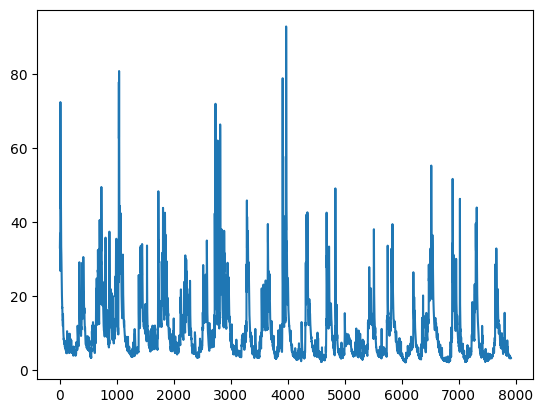

In [6]:
bentfeld_id = runoff["station_name"].values == "BENTFELD"
bentfeld_index = np.where(bentfeld_id)[0][0]

# Select only that timeseries
runoffBentfeld = runoff["runoff_mean"].isel(id=bentfeld_index)
plt.plot(runoffBentfeld)
plt.show()

In [20]:
bentfeld_path = r"data/bentfeld"
treia_path = r"data/catchment_timeseries/treia"
klempenow_path = r"data/catchment_timeseries/klempenow"

temperature = xr.open_mfdataset(bentfeld_path + '/temperature.nc', combine='by_coords').load()
precipitation = xr.open_mfdataset(bentfeld_path + '/precipitation.nc', combine='by_coords').load()
radiation = xr.open_mfdataset(bentfeld_path + '/radiation.nc', combine='by_coords').load()
ndvi = xr.open_mfdataset(bentfeld_path + '/ndvi.nc', combine='by_coords').load()

data = xr.Dataset()
data['temperature'] = temperature['t2m']
data['precipitation'] = precipitation['precipitation']
data['radiation'] = radiation['nr']
data['ndvi'] = ndvi['ndvi']
data['observedRunoff'] = runoffBentfeld.broadcast_like(radiation['nr'])

#get rid of anythin before 2000 and after 2022
data = data.sel(time=slice('2000-03-01', '2022-12-19'))
data

<xarray.Dataset> Size: 7MB
Dimensions:         (time: 8329, x: 5, y: 5)
Coordinates:
  * time            (time) datetime64[ns] 67kB 2000-03-01 ... 2022-12-19
  * x               (x) float64 40B 8.55 8.65 8.75 8.85 8.95
  * y               (y) float64 40B 51.85 51.75 51.65 51.55 51.45
    spatial_ref     int64 8B 0
    id              int32 4B 6335082
Data variables:
    temperature     (time, y, x) float32 833kB nan nan nan ... 276.1 nan nan
    precipitation   (time, y, x) float64 2MB nan nan nan ... 0.004961 nan nan
    radiation       (time, y, x) float64 2MB nan nan nan ... -2.438e+04 nan nan
    ndvi            (time, y, x) float64 2MB nan nan nan ... 0.6008 nan nan
    observedRunoff  (time, y, x) float32 833kB 33.08 33.08 33.08 ... nan nan nan

In [8]:
paramsChoice = {    
    "c_s": [210, 420, 840],
    "alpha": [2, 4, 8],
    "gamma": [0.2, 0.5, 0.8],
    "beta": [0.4, 0.6, 0.8],
    "c_m": [1, 1.5, 2],
    "et_weight": [(0.5, 0.25), (0.75, 0.5), (0.5, 0.5)]
}

start_time = time.time()
cal = Calibrator(paramsChoice=paramsChoice, rasterData=data, amountCombinations=100)
res = cal.calculate_params_whole_catchment()
print(res)
apply_ufunc_duration = time.time() - start_time
print(f"calculations completed in {apply_ufunc_duration:.5f} seconds.")

R: 0.3028134
Best R:  -inf
R: 0.42842627
Best R:  0.3028134


KeyboardInterrupt: 

In [40]:
dataMean = xr.Dataset()
dataMean['temperature'] = data["temperature"].mean(dim=("x", "y"))
dataMean['precipitation'] = data["precipitation"].mean(dim=("x", "y"))
dataMean['radiation'] = data["radiation"].mean(dim=("x", "y"))
dataMean['ndvi'] = data["ndvi"].mean(dim=("x", "y"))
dataMean['observedRunoff'] = data["observedRunoff"].sum(dim=("x", "y"))
#params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
params = [840, 8, 0.5, 0.8, 2.0, (0.75, 0.5)]
wm = WaterModel(params=params, data= dataMean)
runoff = wm.run_simulation_whole_catchment()

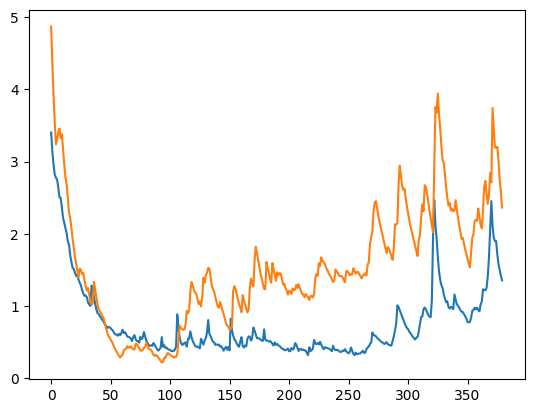

In [41]:
normalized = (data["observedRunoff"]*86400/(1018*1000))
plt.plot(normalized[20:400].mean(dim=("x", "y")))
plt.plot(runoff["runoff"][20:400])
plt.show()

In [23]:
params_new = [840, 8, 0.5, 0.8, 2.0, (0.75, 0.5), 10]
wm_new = WaterModel_New(params=params_new, data= dataMean)
runoff_new = wm_new.run_simulation_whole_catchment()

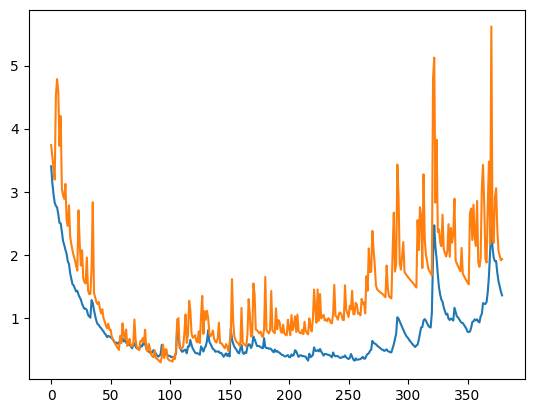

In [24]:
normalized = (data["observedRunoff"]*86400/(1018*1000))


plt.plot(normalized[20:400].mean(dim=("x", "y")))
plt.plot(runoff_new["runoff"][20:400])
plt.show()

In [37]:
x = runoff_new["runoff"][10:400].values.flatten()
y = normalized[10:400].mean(dim=("x", "y")).values.flatten()

# Create a mask for non-NaN values in both arrays
mask = ~np.isnan(x) & ~np.isnan(y)

# Apply the mask and then compute Pearson correlation
r2_new = pearsonr(x[mask], y[mask])[0]
r2_new

np.float32(0.8795932)

In [42]:
x = runoff["runoff"][10:400].values.flatten()
y = normalized[10:400].mean(dim=("x", "y")).values.flatten()

# Create a mask for non-NaN values in both arrays
mask = ~np.isnan(x) & ~np.isnan(y)

# Apply the mask and then compute Pearson correlation
r2 = pearsonr(x[mask], y[mask])[0]
r2

np.float32(0.8203287)

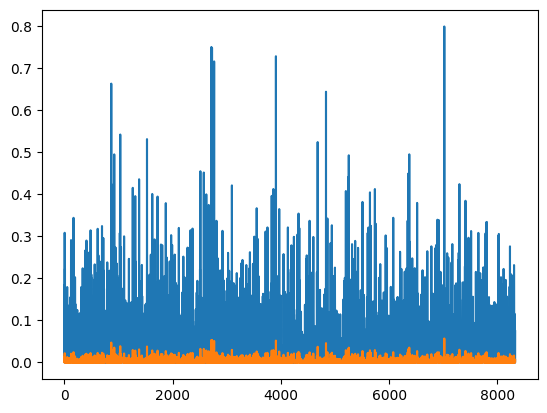

In [ ]:
plt.plot(data["precipitation"].sum(dim=("x", "y")))
plt.plot(data["precipitation"].mean(dim=("x", "y")))

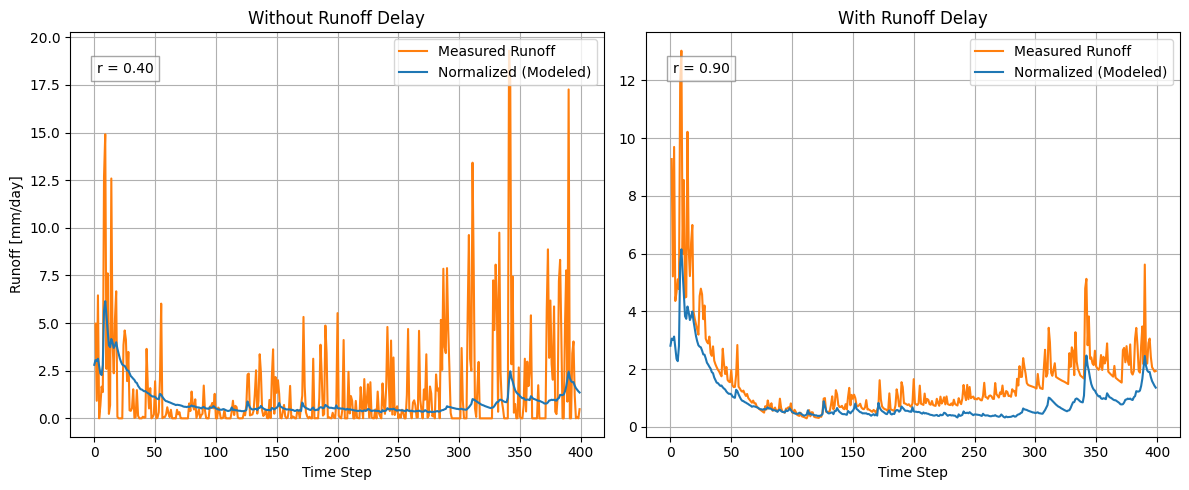

In [ ]:
# Prepare data
mean_normalized = normalized[:400].mean(dim=("x", "y")).values
runoff_orig = runoff["runoff"][:400].values
runoff_delayed = runoff_new["runoff"][:400].values

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot 1: Without Delay
axs[0].plot(runoff_orig, color='tab:orange', label="Measured Runoff")
axs[0].plot(mean_normalized, color='tab:blue', label="Normalized (Modeled)")
axs[0].set_title("Without Runoff Delay")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Runoff [mm/day]")
axs[0].grid(True)
axs[0].text(0.05, 0.90, f"r = {r2:.2f}", transform=axs[0].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# Plot 2: With Delay
axs[1].plot(runoff_delayed, color='tab:orange', label="Modelled")
axs[1].plot(mean_normalized, color='tab:blue', label="Observed")
axs[1].set_title("With Runoff Delay")
axs[1].set_xlabel("Time Step")
axs[1].grid(True)
axs[1].legend(loc="upper right")
axs[1].text(0.05, 0.90, f"r = {r2_new:.2f}", transform=axs[1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# Layout
plt.tight_layout()
plt.show()


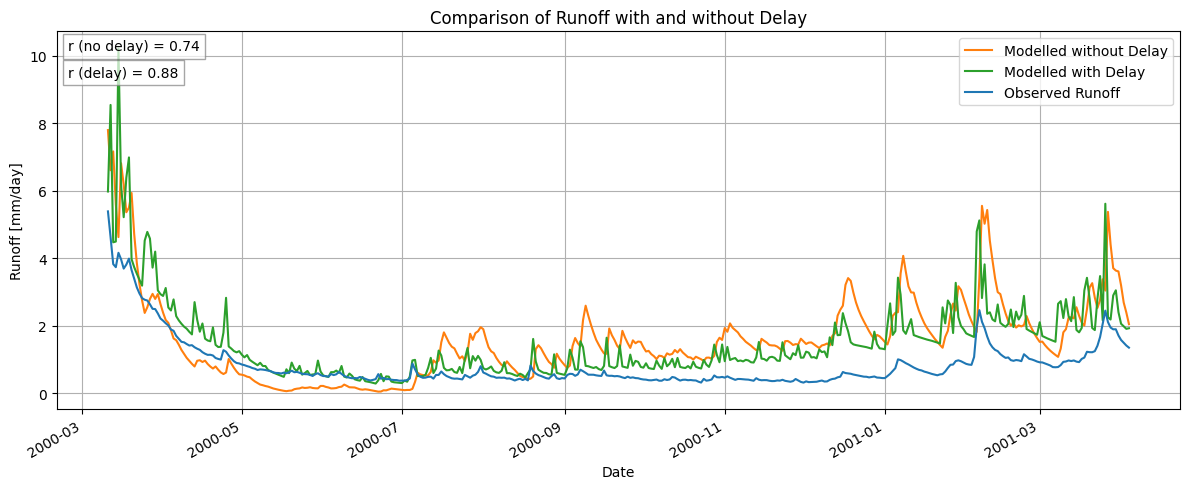

In [39]:
import matplotlib.pyplot as plt

# Prepare data
time = normalized["time"][10:400].values
mean_normalized = normalized[10:400].mean(dim=("x", "y")).values
runoff_orig = runoff["runoff"][10:400].values
runoff_delayed = runoff_new["runoff"][10:400].values

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot all series
ax.plot(time, runoff_orig, color='tab:orange', label="Modelled without Delay")
ax.plot(time, runoff_delayed, color='tab:green', label="Modelled with Delay")
ax.plot(time, mean_normalized, color='tab:blue', label="Observed Runoff")

# Labels and formatting
ax.set_title("Comparison of Runoff with and without Delay")
ax.set_xlabel("Date")
ax.set_ylabel("Runoff [mm/day]")
ax.grid(True)
ax.legend(loc="upper right")

# Optional: Show correlation coefficients as text in the corner
ax.text(0.01, 0.95, f"r (no delay) = {r2:.2f}", transform=ax.transAxes,
        fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
ax.text(0.01, 0.88, f"r (delay) = {r2_new:.2f}", transform=ax.transAxes,
        fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# Improve x-axis formatting
fig.autofmt_xdate()
plt.tight_layout()
plt.show()